# Comparison of scenarios

1. re

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import os

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future'
file_prefix = f'week'
outdir = '2021-01-19-107_90/'

n_int_steps = 6
nnodes = 107  # nodes
ndays_ocp = 90
ndays = 180

setup = ItalySetup(nnodes, ndays, when)
setup_ocp = ItalySetup(nnodes, ndays_ocp, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)
    
os.makedirs('model_output/scenarios', exist_ok=True)

scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(30)}
scenarios.keys()

Loaded Italy Setup with 107 nodes.
Loaded Italy Setup with 107 nodes.


dict_keys(['U-r1-t125000-id0', 'L-r1-t125000-id1', 'U-r2-t125000-id2', 'L-r2-t125000-id3', 'U-r15-t125000-id4', 'L-r15-t125000-id5', 'U-r1-t250000-id6', 'L-r1-t250000-id7', 'U-r2-t250000-id8', 'L-r2-t250000-id9', 'U-r15-t250000-id10', 'L-r15-t250000-id11', 'U-r1-t479700-id12', 'L-r1-t479700-id13', 'U-r2-t479700-id14', 'L-r2-t479700-id15', 'U-r15-t479700-id16', 'L-r15-t479700-id17', 'U-r1-t1000000-id18', 'L-r1-t1000000-id19', 'U-r2-t1000000-id20', 'L-r2-t1000000-id21', 'U-r15-t1000000-id22', 'L-r15-t1000000-id23', 'U-r1-t2000000-id24', 'L-r1-t2000000-id25', 'U-r2-t2000000-id26', 'L-r2-t2000000-id27', 'U-r15-t2000000-id28', 'L-r15-t2000000-id29'])

In [3]:
import glob
baseline_fn = glob.glob('model_output/scenarios/*novacc*.csv')

scenarios_baseline = {}
for fn in baseline_fn:
    scenarios_baseline[fn.split('-')[0][-1]] = pd.read_csv(fn, index_col= 'date', parse_dates=True)

In [4]:
scn_results = pd.DataFrame(columns=['newdoseperweek', 'method', 'infected'])
methods = ['opi','cas', 'inc', 'pop', 'sus'] # 'opt'
for met in methods:
    for scenario_name, scenario in scenarios.items():
        filename = f'model_output/scenarios/{scenario_name}-{met}-{nnodes}_{ndays}.csv'
        if os.path.isfile(filename):
            maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
            dosesperweek = int(scenario_name.split('-')[2][1:])
            ratepermonth = int(scenario_name.split('-')[1][1:])*1e6
            md = pd.read_csv(filename, index_col= 'date', parse_dates=True)
            infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()
            doses = md[md['comp']=='vacc']['value'].sum()
            nv = scenarios_baseline[scenario_name.split('-')[0]]
            baseline_infected = nv[(nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])) & (nv.index == str(setup.end_date))]['value'].sum()
            scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'newdoseperweek':[dosesperweek],
                                                                          'method': [met],
                                                                          'infected':[infected],
                                                                           'doses': [doses],
                                                                           'scenario-beta': [scenario_name.split('-')[0]],
                                                                           'scenario-rate': [scenario_name.split('-')[1]],
                                                                           'scenario-tot': [scenario_name.split('-')[2]],
                                                                           'scenario': scenario_name,
                                                                           'averted': baseline_infected - infected
                                                                         })])
        else:
            print(f"NOT {scenario_name}")
   
scn_results['avertedpervacc'] = scn_results['averted']/scn_results['doses']

#scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('opi', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('cas', 'Future Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)
scn_results.replace('sus', 'Susceptibility', inplace=True)

In [ ]:
scn_results['scenario-tot'].unique()

In [ ]:
scn_results[scn_results['scenario-tot']=='t1000000']

In [38]:
scn_results

,newdoseperweek,method,infected,doses,scenario-beta,scenario-rate,scenario-tot,scenario,averted,avertedpervacc
0,125000,Optimal,1.126662e+07,1.566664e+06,U,r1,t125000,U-r1-t125000-id0,1.659059e+06,1.058976
0,125000,Optimal,4.786826e+06,1.565346e+06,L,r1,t125000,L-r1-t125000-id1,5.649364e+04,0.036090
0,125000,Optimal,1.098039e+07,1.625000e+06,U,r2,t125000,U-r2-t125000-id2,1.945288e+06,1.197100
0,125000,Optimal,4.754126e+06,1.624997e+06,L,r2,t125000,L-r2-t125000-id3,8.919340e+04,0.054888
0,125000,Optimal,1.104513e+07,1.625000e+06,U,r15,t125000,U-r15-t125000-id4,1.880549e+06,1.157261
...,...,...,...,...,...,...,...,...,...,...
0,2000000,Susceptibility,4.781033e+06,2.866667e+06,L,r1,t2000000,L-r1-t2000000-id25,6.228638e+04,0.021728
0,2000000,Susceptibility,9.539389e+06,5.733333e+06,U,r2,t2000000,U-r2-t2000000-id26,3.386294e+06,0.590633
0,2000000,Susceptibility,4.726468e+06,5.733333e+06,L,r2,t2000000,L-r2-t2000000-id27,1.168517e+05,0.020381
0,2000000,Susceptibility,5.965111e+06,2.499106e+07,U,r15,t2000000,U-r15-t2000000-id28,6.960571e+06,0.278522


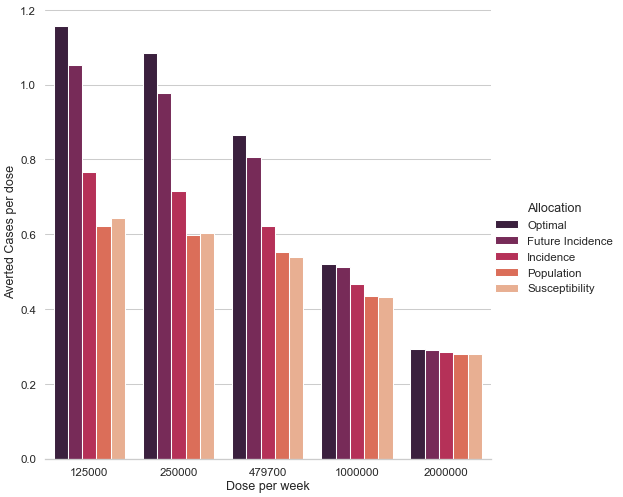

In [5]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=scn_results[(scn_results['scenario-rate']=='r15') & (scn_results['scenario-beta']=='U')],
    kind="bar",
    x="newdoseperweek",
    y="avertedpervacc", 
    #y="averted",
    hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Dose per week", "Averted Cases per dose")
g.legend.set_title("Allocation")
#g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])

g.fig.savefig('figures/scenarios.pdf')

In [ ]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,15), 'figure.dpi':200})
sns.set_theme(style="whitegrid")
#sns.set_context("talk")

g = sns.catplot(
    data=scn_results,
    kind="bar",
    x="scenario",
    y="avertedpervacc", 
    #y="averted",
    hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Dose per week", "Averted Cases per dose")
g.legend.set_title("Allocation")
g.set_xticklabels(rotation=90)
#g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])

In [ ]:
g = sns.lineplot(
    data=scn_results, 
    x="scenario", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

In [ ]:
scn_results_ts = {}
methods = ['opi', 'inc', 'pop', 'sus', 'cas'] # 'opt'
for met in methods:
    for scenario_name, scenario in scenarios_opt.items():
        maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
        dosesperweek = int(scenario_name.split('-')[2][1:])
        ratepermonth = int(scenario_name.split('-')[1][1:])*1e6
        md = pd.read_csv(f'model_output/scenarios/{scenario_name}-{met}-{nnodes}_{ndays}.csv', index_col= 'date', parse_dates=True)
        scn_results_ts[met+'-'+scenario_name] = md[md.index < str(setup_ocp.end_date)]

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (20,10), dpi=200)
fig.patch.set_facecolor('white')

nd = 0

sp = []

for name, ts in scn_results_ts.items():
    if name.split('-')[-2] not in sp:
        sp.append(name.split('-')[-2])
    ax = axes.flat[sp.index(name.split('-')[-2])]
    
    ax.plot(ts[ts['comp']=='vacc'].pivot(columns = 'place', values='value').cumsum().sum(axis=1), linestyle='-.', lw = 2, label=name.split('-')[0], alpha = .9)
    ax.set_title(name.split('-')[-2]);
    ax.legend()

In [152]:
summary = pd.read_csv('model_output/scenarios/all_summary.csv', index_col=0)
summary.replace('opi', 'Optimal', inplace=True)
summary.replace('int', 'Uniform', inplace=True)
summary.replace('inc', 'Incidence', inplace=True)
summary.replace('cas', 'Future Incidence', inplace=True)
summary.replace('pop', 'Population', inplace=True)
summary.replace('sus', 'Susceptibility', inplace=True)
summary.replace('U', 'High transmission', inplace=True)
summary.replace('L', 'Low transmission', inplace=True)

In [153]:
summary

,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc
0,125000,Optimal,6.004858e+08,0.0,1.566664e+06,High transmission,r1,t125000,U-r1-t125000-id0,6.101198e+08,9.634039e+06,6.149397
1,125000,Optimal,1.025928e+09,1.0,1.566664e+06,High transmission,r1,t125000,U-r1-t125000-id0,1.044931e+09,1.900305e+07,12.129629
2,125000,Optimal,6.361166e+08,2.0,1.566664e+06,High transmission,r1,t125000,U-r1-t125000-id0,6.448196e+08,8.702985e+06,5.555106
3,125000,Optimal,1.076014e+09,3.0,1.566664e+06,High transmission,r1,t125000,U-r1-t125000-id0,1.094167e+09,1.815359e+07,11.587416
4,125000,Optimal,6.857489e+08,4.0,1.566664e+06,High transmission,r1,t125000,U-r1-t125000-id0,6.927140e+08,6.965141e+06,4.445842
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2000000,Susceptibility,1.316082e+08,95.0,2.499106e+07,Low transmission,r15,t2000000,L-r15-t2000000-id29,1.381956e+08,6.587377e+06,0.263589
96,2000000,Susceptibility,1.126511e+08,96.0,2.499106e+07,Low transmission,r15,t2000000,L-r15-t2000000-id29,1.173939e+08,4.742858e+06,0.189782
97,2000000,Susceptibility,1.412437e+08,97.0,2.499106e+07,Low transmission,r15,t2000000,L-r15-t2000000-id29,1.485987e+08,7.354985e+06,0.294305
98,2000000,Susceptibility,1.321285e+08,98.0,2.499106e+07,Low transmission,r15,t2000000,L-r15-t2000000-id29,1.397171e+08,7.588535e+06,0.303650


In [239]:
scn = 'L'
smry = summary[(summary['scenario-rate']=='r15') & (summary['scenario-beta']==scn)]

sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':100})
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=smry,
    kind="boxen",
    x="newdoseperweek",
    y="avertedpervacc", 
    hue="method",
    palette="rocket",
    dodge=.59,
    height=8,
    #alpha = .4,
    #inner="stick"
    legend=False,
    showfliers=False
)
g2 = sns.pointplot(x="newdoseperweek",
              y="avertedpervacc", 
              data = smry[smry['post_sample']==64], 
              dodge=.59, 
              join=False, 
              #palette="cool",
              hue="method",
              palette="mako_r",
              markers="d", 
              scale=1.25, 
              ci=None,
              zorder=100000,
              #legend=False
             )

plt.setp(g.ax.lines, zorder=100)
plt.setp(g.ax.collections, zorder=100, label="")
g.despine(left=True)
g.set_axis_labels("Dose per week", "Averted Cases per dose")
#g2.legend.set_title("Allocation")


g.fig.savefig(f'figures/scenarios_perturb{scn}.pdf')

ValueError: min() arg is an empty sequence

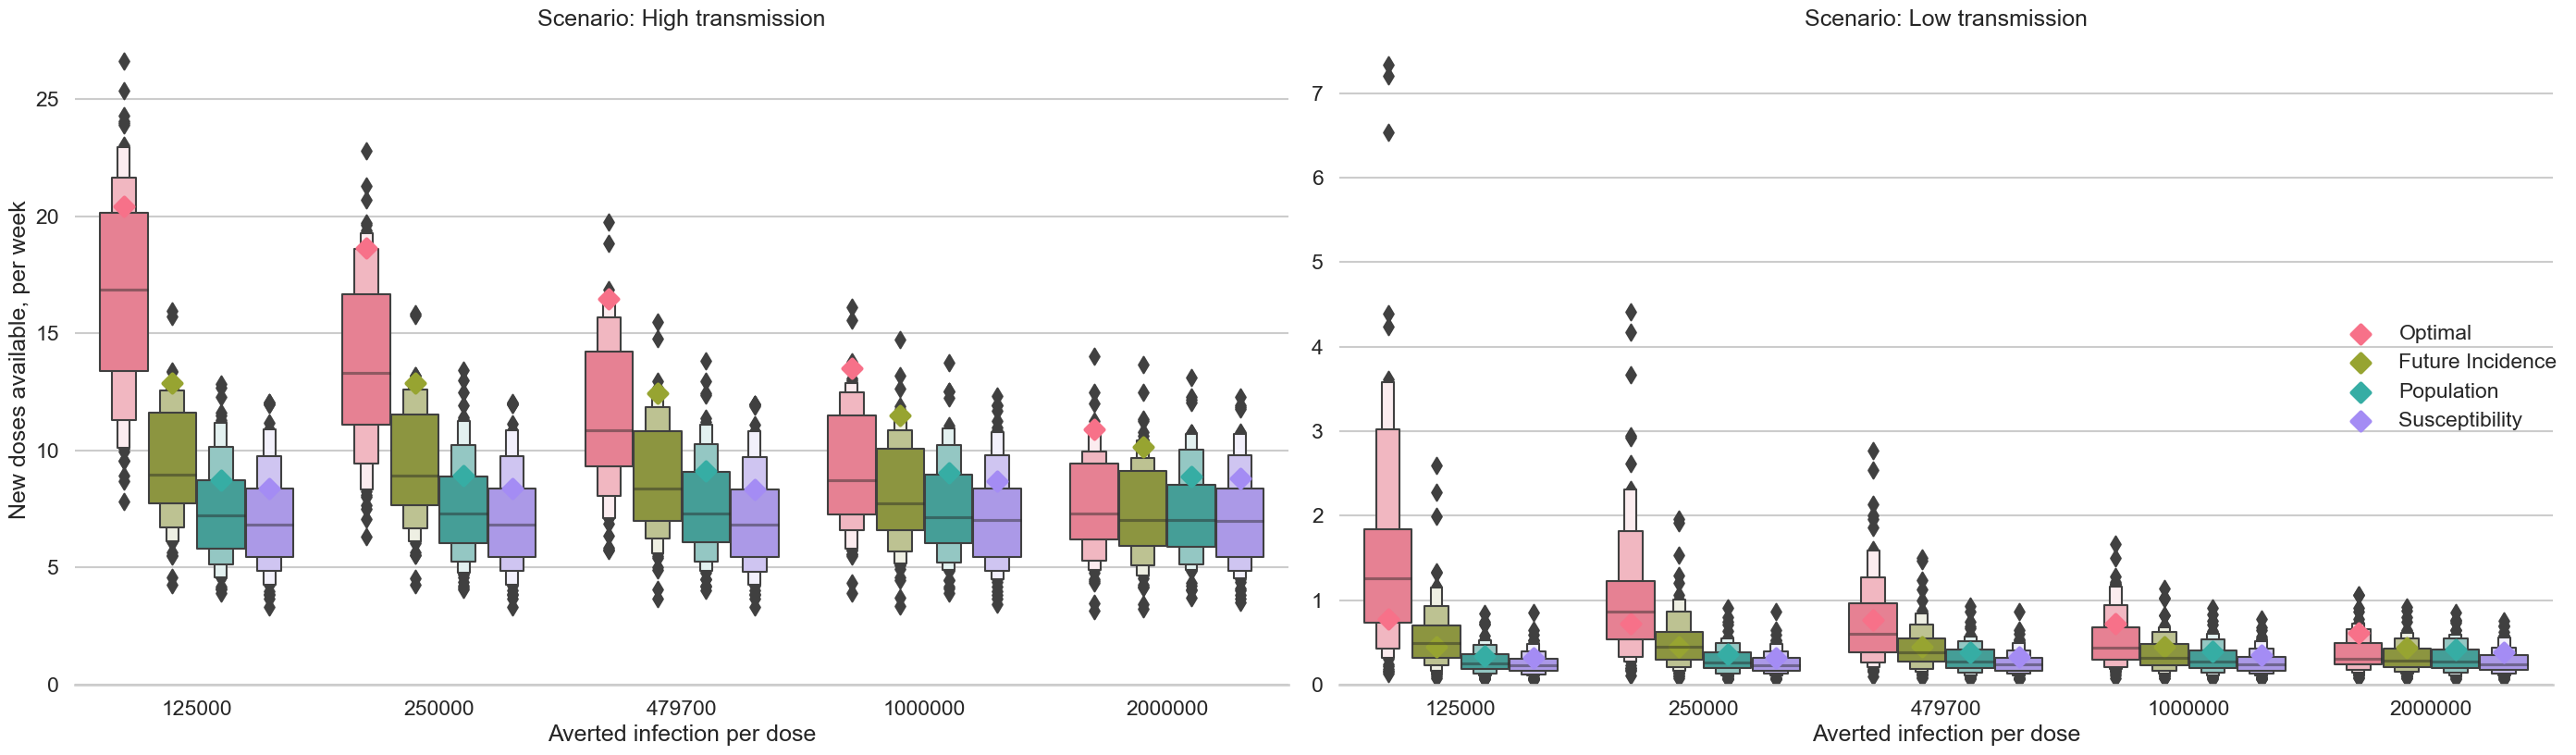

In [244]:
smry = summary[(summary['scenario-rate']=='r15')]

grid = sns.FacetGrid(smry, col="scenario-beta",  palette="mako", height=8.5, aspect = 1.5, col_wrap=2, sharey=False,sharex=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g = sns.boxenplot(
        #data=smry,,
        x=index, y=reduction,
        hue=method,
        palette="husl",
        dodge=9,
        #size=2,
        #alpha = .4,
        #inner="stick"
        #legend=False,
        #showfliers=False
    )
    ax = plt.gca()
    ax.set_ylim(0)

    g2 = sns.pointplot(x="newdoseperweek", y="avertedpervacc",
          data = smry[(smry['post_sample']==64) & (smry['scenario-beta']==scn_beta.unique()[0])], 
          dodge=.60, 
          join=False, 
          #palette="cool",
          hue="method",
          palette="husl",
          markers="D", 
          scale=1, 
          ci=None,
          zorder=100000,
                       edgecolor='black',
                       hatch = "|",
                        linewidth=3,
                       markeredgewidth=4, #markeredgecolor=(1, 1, 1, 0)
          #legend=True
         )



   
    
    #sns.violinplot(x=index, y=reduction, #hue="geoid",
    #               dodge=True,  zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    #sns.pointplot(x="index", y="reduction", data = npi_truth[npi_truth['geoid']==kwargs['label']], dodge=.532, join=False, #palette="dark",
    #          markers="d", scale=1.75, ci=None,zorder=102, color="black")
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, "newdoseperweek", "avertedpervacc", "method", "scenario-beta")#, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)

grid.set_axis_labels("Averted infection per dose", "New doses available, per week")
grid.set_titles(col_template="Scenario: {col_name}", row_template="{row_name}")
grid.add_legend()
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/scenarios_perturb_all.pdf')

In [61]:
smry[smry['avertedpervacc'] < 0]

,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc


In [213]:
sn

NameError: name 'sn' is not defined

,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc
64,125000,opi,9.801593e+08,64.0,1.625000e+06,U,r15,t125000,U-r15-t125000-id4,1.013345e+09,3.318549e+07,20.421839
64,250000,opi,9.527705e+08,64.0,3.250000e+06,U,r15,t250000,U-r15-t250000-id10,1.013345e+09,6.057431e+07,18.638251
64,479700,opi,9.106863e+08,64.0,6.236100e+06,U,r15,t479700,U-r15-t479700-id16,1.013345e+09,1.026585e+08,16.461971
64,1000000,opi,8.382537e+08,64.0,1.297121e+07,U,r15,t1000000,U-r15-t1000000-id22,1.013345e+09,1.750910e+08,13.498432
64,2000000,opi,7.420616e+08,64.0,2.491384e+07,U,r15,t2000000,U-r15-t2000000-id28,1.013345e+09,2.712832e+08,10.888853
64,125000,cas,9.926378e+08,64.0,1.608347e+06,U,r15,t125000,U-r15-t125000-id4,1.013345e+09,2.070701e+07,12.874710
64,250000,cas,9.719664e+08,64.0,3.216392e+06,U,r15,t250000,U-r15-t250000-id10,1.013345e+09,4.137836e+07,12.864836
64,479700,cas,9.367470e+08,64.0,6.159978e+06,U,r15,t479700,U-r15-t479700-id16,1.013345e+09,7.659775e+07,12.434743
64,1000000,cas,8.678225e+08,64.0,1.267881e+07,U,r15,t1000000,U-r15-t1000000-id22,1.013345e+09,1.455223e+08,11.477598
64,2000000,cas,7.611833e+08,64.0,2.486851e+07,U,r15,t2000000,U-r15-t2000000-id28,1.013345e+09,2.521615e+08,10.139789
